In [1]:
import pandas as pd 
import numpy as np
from tqdm.auto import tqdm
import dill
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
events = pd.read_parquet('./sample_data/fold1/fit/smm_train_events.parquet')
user_feat = pd.read_parquet('./sample_data/fold1/fit/user_features.parquet')
user_tags = pd.read_parquet('./sample_data/fold1/fit/user_tags.parquet')

In [3]:
item_feat = events[['item_id', 'category_id']]
events = events.drop(['category_id'], axis=1)

In [4]:
events.head()

,user_id,item_id,event,datetime
0,3386880,3108429,2,2023-02-10 21:34:17.677
1,2404320,2896309,2,2023-02-10 17:58:59.987
2,4664651,1545131,0,2023-02-10 09:40:22.000
3,3630190,401021,0,2023-02-10 12:30:29.000
4,3873537,572913,0,2023-02-10 13:12:18.000


In [5]:
max_date = events['datetime'].max()
min_date = events['datetime'].min()

min_date, max_date

(Timestamp('2023-01-15 01:20:07'), Timestamp('2023-02-12 23:58:02'))

In [6]:
train = events[(events['datetime'] < max_date - pd.Timedelta(days=7))]
test = events[(events['datetime'] >= max_date - pd.Timedelta(days=7))]

print(f"train: {train.shape}")
print(f"test: {test.shape}")

train: (46368, 4)
test: (16847, 4)


In [7]:
lfm_date_threshold = events['datetime'].quantile(q=0.6, interpolation='nearest')
lfm_date_threshold

Timestamp('2023-02-02 02:25:07.411000')

In [8]:
lfm_train = events[(events['datetime'] < lfm_date_threshold)]
lfm_pred = events[(events['datetime'] >= lfm_date_threshold)]

print(f"lfm_train: {lfm_train.shape}")
print(f"lfm_pred: {lfm_pred.shape}")

lfm_train: (37928, 4)
lfm_pred: (25287, 4)


In [9]:
lfm_pred = lfm_pred[lfm_pred['user_id'].isin(lfm_train['user_id'].unique())]

In [10]:
from lightfm.data import Dataset
from lightfm import LightFM

In [11]:
dataset = Dataset()
dataset.fit(lfm_train['user_id'].unique(), lfm_train['item_id'].unique())

In [12]:
interactions_matrix, weights_matrix = dataset.build_interactions(
    zip(*lfm_train[['user_id', 'item_id', 'event']].values.T)
)

weights_matrix_csr = weights_matrix.tocsr()

In [13]:
lightfm_mapping = dataset.mapping()
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'items_mapping': lightfm_mapping[2],
}

lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

print(f"users_mapping amount: {len(lightfm_mapping['users_mapping'])}")
print(f"items_mapping amount: {len(lightfm_mapping['items_mapping'])}")

users_mapping amount: 1165
items_mapping amount: 11242


In [14]:
lfm_model = LightFM(
    no_components=64, 
    learning_rate=0.1, 
    loss='warp', 
    max_sampled=5, 
    random_state=42
)

In [15]:
num_epochs = 20

for _ in tqdm(range(num_epochs)):
    lfm_model.fit_partial(
        weights_matrix_csr
    )

  0%|          | 0/20 [00:00<?, ?it/s]

In [16]:
with open(f"lfm_model.dill", 'wb') as f:
    dill.dump(lfm_model, f)

In [17]:
def generate_lightfm_recs_mapper(model, item_ids, known_items, 
                                 user_features, item_features, N, 
                                 user_mapping, item_inv_mapping, 
                                 num_threads=1):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.predict(user_id, item_ids, user_features=user_features, 
                             item_features=item_features, num_threads=num_threads)
        
        additional_N = len(known_items[user_id]) if user_id in known_items else 0
        total_N = N + additional_N
        top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]
        
        final_recs = [item_inv_mapping[item] for item in top_cols]
        if additional_N > 0:
            filter_items = known_items[user_id]
            final_recs = [item for item in final_recs if item not in filter_items]
        return final_recs[:N]
    return _recs_mapper


def compute_metrics(df_true, df_pred, top_N, rank_col='rank'):
    result = {}
    test_recs = df_true.set_index(['user_id', 'item_id']).join(df_pred.set_index(['user_id', 'item_id']))
    test_recs = test_recs.sort_values(by=['user_id', rank_col])

    test_recs['users_item_count'] = test_recs.groupby(level='user_id')[rank_col].transform(np.size)
    test_recs['reciprocal_rank'] = (1 / test_recs[rank_col]).fillna(0)
    test_recs['cumulative_rank'] = test_recs.groupby(level='user_id').cumcount() + 1
    test_recs['cumulative_rank'] = test_recs['cumulative_rank'] / test_recs[rank_col]
    
    users_count = test_recs.index.get_level_values('user_id').nunique()
    for k in range(1, top_N + 1):
        hit_k = f'hit@{k}'
        test_recs[hit_k] = test_recs[rank_col] <= k
        result[f'Precision@{k}'] = (test_recs[hit_k] / k).sum() / users_count
        result[f'Recall@{k}'] = (test_recs[hit_k] / test_recs['users_item_count']).sum() / users_count

    result[f'MAP@{top_N}'] = (test_recs["cumulative_rank"] / test_recs["users_item_count"]).sum() / users_count
    result[f'MRR'] = test_recs.groupby(level='user_id')['reciprocal_rank'].max().mean()
    return pd.Series(result)


In [18]:
candidates = pd.DataFrame({
    'user_id': lfm_pred['user_id'].unique()
})

candidates.head(3)

,user_id
0,2404320
1,4664651
2,3630190


In [19]:
top_N = 30

all_cols = list(lightfm_mapping['items_mapping'].values())

mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids=all_cols, 
    known_items=dict(),
    N=top_N,
    user_features=None, 
    item_features=None, 
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=20
)

In [20]:
candidates['item_id'] = candidates['user_id'].map(mapper)
candidates = candidates.explode('item_id')
candidates['rank'] = candidates.groupby('user_id').cumcount() + 1 

candidates.head()

,user_id,item_id,rank
0,2404320,452365,1
0,2404320,1290849,2
0,2404320,2344401,3
0,2404320,2804677,4
0,2404320,649181,5


In [21]:
candidates.shape

(15750, 3)

In [22]:
pos = candidates.merge(lfm_pred,
                        on=['user_id', 'item_id'],
                        how='inner')

pos['target'] = 1
print(pos.shape)
pos.head()

(1916, 6)


,user_id,item_id,rank,event,datetime,target
0,5755584,459886,1,2,2023-02-02 09:11:57.376,1
1,5755584,459886,1,2,2023-02-02 09:11:57.645,1
2,5755584,107755,9,2,2023-02-10 09:06:01.872,1
3,5755584,107755,9,2,2023-02-10 09:06:01.747,1
4,5755584,107755,9,2,2023-02-02 12:46:06.496,1


In [23]:
neg = candidates.set_index(['user_id', 'item_id'])\
        .join(lfm_pred.set_index(['user_id', 'item_id']))

neg = neg[neg['event'].isnull()].reset_index()

neg = neg.sample(frac=0.07)
neg['target'] = 0

neg.shape

(1073, 6)

In [24]:
ctb_train_users, ctb_test_users = train_test_split(lfm_pred['user_id'].unique(),
                                                  random_state=1,
                                                  test_size=0.2)

In [25]:
ctb_train_users, ctb_eval_users = train_test_split(ctb_train_users,
                                                  random_state=1,
                                                  test_size=0.1)

In [26]:
select_col = ['user_id', 'item_id', 'rank', 'target']

# Catboost train
ctb_train = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_train_users)],
        neg[neg['user_id'].isin(ctb_train_users)]
])[select_col]
)

# Catboost test
ctb_test = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_test_users)],
        neg[neg['user_id'].isin(ctb_test_users)]
])[select_col]
)

# for early stopping
ctb_eval = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_eval_users)],
        neg[neg['user_id'].isin(ctb_eval_users)]
])[select_col]
)

In [27]:
ctb_train['target'].value_counts(normalize=True)

1    0.634634
0    0.365366
Name: target, dtype: float64

In [28]:
ctb_test['target'].value_counts(normalize=True)

1    0.62585
0    0.37415
Name: target, dtype: float64

In [29]:
user_col = ['user_id', 'age', 'income', 'sex', 'kids_flg']
item_col = ['item_id', 'content_type', 'countries', 'for_kids', 'age_rating', 'studios']

In [30]:
train_feat = ctb_train.merge(user_feat,
                           on=['user_id'],
                           how='left')

eval_feat = ctb_eval.merge(user_feat,
                           on=['user_id'],
                           how='left')

In [31]:
drop_col = ['user_id', 'item_id', 'report_dt', 'f163']
target_col = ['target']

In [32]:
X_train, y_train = train_feat.drop(drop_col + target_col, axis=1), train_feat[target_col]
X_val, y_val = eval_feat.drop(drop_col + target_col, axis=1), eval_feat[target_col]

In [33]:
X_train

,rank,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162
0,16,6.0,-0.067670,0.0,1.358098,NaN,0.267180,-0.036908,0.031101,0.359316,...,-0.279869,0.0,0.280952,1.740793,NaN,1.534635,1.0,NaN,-1.031667,3.740928
1,6,5.0,-0.067670,0.0,NaN,NaN,0.101772,-0.037638,-0.013597,-0.121223,...,-0.492888,0.0,-0.055338,0.320798,1.368962,-0.310763,1.0,0.177907,NaN,-0.750813
2,28,4.0,-0.790499,0.0,-0.327611,2.096018,-0.100892,-0.037598,-0.041235,0.432125,...,-0.279869,0.0,-0.118417,-0.112813,-0.995882,-0.473592,1.0,NaN,NaN,-0.513266
3,5,6.0,-0.067670,0.0,NaN,NaN,0.293650,-0.037400,0.166120,0.359316,...,-0.279869,0.0,0.640666,0.291008,0.142502,-0.093657,1.0,NaN,0.640900,-0.746928
4,11,3.0,-0.790499,0.0,NaN,NaN,-0.167011,NaN,-0.038739,-1.038616,...,NaN,0.0,-0.138801,-0.286589,NaN,-0.365039,1.0,-0.067375,NaN,0.394184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2097,11,5.0,2.100816,0.0,1.358098,NaN,0.180008,0.012355,0.027800,0.373877,...,-0.492888,0.0,0.001043,0.231428,NaN,-0.473592,1.0,0.246313,NaN,-0.765798
2098,4,3.0,-0.790499,0.0,NaN,1.674893,-0.122071,-0.033506,0.409393,-0.237718,...,1.850312,0.0,-0.083715,0.281078,-0.591285,-0.419316,1.0,-0.030013,NaN,-0.760803
2099,4,5.0,1.377987,0.0,NaN,NaN,-0.053874,-0.037612,-0.035133,0.228260,...,NaN,0.0,-0.017604,0.679934,NaN,NaN,1.0,NaN,NaN,-0.264064
2100,5,3.0,0.655159,0.0,NaN,NaN,0.105586,-0.037637,-0.031825,-0.732819,...,0.998240,1.0,-0.063612,-0.000273,1.343893,-0.419316,1.0,0.273887,NaN,-0.142516


In [34]:
X_train = X_train.fillna(X_train.mode().iloc[0])
X_val = X_val.fillna(X_train.mode().iloc[0])

In [35]:
from catboost import CatBoostClassifier

est_params = {
  'subsample': 0.9,
  'max_depth': 5,
  'n_estimators': 2000,
  'learning_rate': 0.1,
  'thread_count': 20,
  'random_state': 42,
  'verbose': 200,
}

ctb_model = CatBoostClassifier(**est_params)

In [36]:
ctb_model.fit(X_train,
              y_train,
              eval_set=(X_val, y_val),
              early_stopping_rounds=100,)

TBB Warning: The number of workers is currently limited to 11. The request for 19 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



0:	learn: 0.6637184	test: 0.7022395	best: 0.7022395 (0)	total: 48.1ms	remaining: 1m 36s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6978968889
bestIteration = 13

Shrink model to first 14 iterations.


In [37]:
with open(f"ctb_model.dill", 'wb') as f:
    dill.dump(ctb_model, f)

In [38]:
test_feat = ctb_test.merge(user_feat,
                           on=['user_id'],
                           how='left')

In [39]:
test_feat = test_feat.fillna(X_train.mode().iloc[0])

In [40]:
X_test, y_test = test_feat.drop(drop_col + target_col, axis=1), test_feat['target']

In [41]:
X_test.head()

,rank,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162
0,12,4.0,0.655159,0.0,-0.327611,-0.838613,0.134353,-0.036688,-0.018752,1.713562,...,-0.066851,0.0,0.034045,0.373758,0.641960,-0.093657,1.0,-0.182737,0.178546,-0.689206
1,22,4.0,-0.790499,0.0,-0.327611,-0.698238,-0.090526,-0.006228,-0.035421,0.082642,...,-0.279869,0.0,-0.076884,0.201638,-1.380274,0.557660,1.0,-0.131154,0.178546,-0.672001
2,10,5.0,-0.067670,0.0,-0.327611,-0.838613,-0.167205,-0.037638,-0.030804,-0.747380,...,-0.492888,0.0,0.014177,-0.225354,0.641960,-0.419316,1.0,-0.030013,0.178546,-0.690871
3,4,3.0,0.655159,0.0,1.358098,-0.790938,-0.151595,-0.034355,-0.051648,0.373877,...,-0.279869,0.0,-0.120054,-0.241904,0.641960,-0.310763,1.0,-0.101013,0.178546,0.134437
4,16,6.0,0.655159,0.0,-0.327611,2.085423,0.982819,-0.037638,0.099054,0.912664,...,-0.279869,1.0,0.105183,0.423409,0.641960,1.534635,1.0,-0.030013,-1.036231,-0.658680


In [42]:
y_pred = ctb_model.predict_proba(X_test)

In [43]:
from sklearn.metrics import roc_auc_score

f"ROC AUC score = {roc_auc_score(y_test, y_pred[:, 1]):.2f}"

'ROC AUC score = 0.60'

In [44]:
test = test[test['user_id'].isin(lfm_train['user_id'].unique())]

In [45]:
# кол-во кандидатов берем больше, чем для обучения
# чтобы катбусту было, что ранжировать
top_N = 200

lfm_prediction = pd.DataFrame({
    'user_id': test['user_id'].unique()
})

known_items = lfm_train.groupby('user_id')['item_id'].apply(list).to_dict()

mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids=all_cols, 
    known_items=known_items,
    N=top_N,
    user_features=None, 
    item_features=None, 
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=20
)

lfm_prediction['item_id'] = lfm_prediction['user_id'].map(mapper)
lfm_prediction = lfm_prediction.explode('item_id').reset_index(drop=True)
lfm_prediction['rank'] = lfm_prediction.groupby('user_id').cumcount() + 1 

In [46]:
lfm_metrics = compute_metrics(test[['user_id', 'item_id']],
                              lfm_prediction, 
                              top_N=10)
lfm_metrics

Precision@1     0.168950
Recall@1        0.008316
Precision@2     0.116438
Recall@2        0.013083
Precision@3     0.109589
Recall@3        0.018867
Precision@4     0.108447
Recall@4        0.023080
Precision@5     0.094064
Recall@5        0.026590
Precision@6     0.086758
Recall@6        0.028918
Precision@7     0.100457
Recall@7        0.030705
Precision@8     0.096176
Recall@8        0.031444
Precision@9     0.091578
Recall@9        0.033152
Precision@10    0.087671
Recall@10       0.035995
MAP@10          0.067661
MRR             0.085257
dtype: float64

In [47]:
lfm_ctb_prediction = lfm_prediction.copy()

# фичи для теста
score_feat = lfm_ctb_prediction.merge(user_feat,
                                   on=['user_id'],
                                   how='left')
# fillna for catboost with the most frequent value 
score_feat = score_feat.fillna(X_train.mode().iloc[0])

In [48]:
ctb_prediction = ctb_model.predict_proba(score_feat.drop(drop_col, axis=1, errors='ignore'))

lfm_ctb_prediction['ctb_pred'] = ctb_prediction[:, 1]
lfm_ctb_prediction.head(3)

,user_id,item_id,rank,ctb_pred
0,2404320,452365,1,0.444957
1,2404320,1290849,2,0.444957
2,2404320,2344401,3,0.444957


In [49]:
lfm_prediction.sort_values(
    by=['user_id'], ascending=[True]).head(10)

,user_id,item_id,rank
16199,1013292,1477353,200
16126,1013292,1000682,127
16127,1013292,555570,128
16128,1013292,1223027,129
16129,1013292,1985328,130
16130,1013292,2949071,131
16131,1013292,3352565,132
16132,1013292,617503,133
16133,1013292,2720758,134
16134,1013292,2618894,135


In [50]:
lfm_ctb_prediction = lfm_ctb_prediction.sort_values(
    by=['user_id', 'ctb_pred'], ascending=[True, False])
lfm_ctb_prediction['rank_ctb'] = lfm_ctb_prediction.groupby('user_id').cumcount() + 1

In [51]:
lfm_ctb_prediction.head(10)

,user_id,item_id,rank,ctb_pred,rank_ctb
16000,1013292,3014073,1,0.463954,1
16001,1013292,2359194,2,0.463954,2
16002,1013292,695008,3,0.463954,3
16003,1013292,757894,4,0.463954,4
16004,1013292,1734930,5,0.463954,5
16005,1013292,1580881,6,0.463954,6
16006,1013292,50578,7,0.463954,7
16007,1013292,3303625,8,0.463954,8
16008,1013292,1610804,9,0.463954,9
16009,1013292,31394,10,0.463954,10


In [53]:
model_2step_metrics = compute_metrics(test[['user_id', 'item_id']],
                                       lfm_ctb_prediction, 
                                       top_N=10, 
                                       rank_col='rank_ctb')
model_2step_metrics

Precision@1     0.171233
Recall@1        0.008636
Precision@2     0.140411
Recall@2        0.016512
Precision@3     0.128615
Recall@3        0.022453
Precision@4     0.123858
Recall@4        0.026679
Precision@5     0.105023
Recall@5        0.027803
Precision@6     0.095510
Recall@6        0.029963
Precision@7     0.109589
Recall@7        0.032349
Precision@8     0.103311
Recall@8        0.033261
Precision@9     0.098935
Recall@9        0.035440
Precision@10    0.095890
Recall@10       0.037711
MAP@10          0.073124
MRR             0.084904
dtype: float64

In [54]:
df_metrics = pd.concat([
    pd.DataFrame(lfm_metrics).transpose(),
    pd.DataFrame(model_2step_metrics).transpose()
])

df_metrics.index = ['lightfm', 'model_2step']

df_metrics

,Precision@1,Recall@1,Precision@2,Recall@2,Precision@3,Recall@3,Precision@4,Recall@4,Precision@5,Recall@5,...,Precision@7,Recall@7,Precision@8,Recall@8,Precision@9,Recall@9,Precision@10,Recall@10,MAP@10,MRR
lightfm,0.168950,0.008316,0.116438,0.013083,0.109589,0.018867,0.108447,0.023080,0.094064,0.026590,...,0.100457,0.030705,0.096176,0.031444,0.091578,0.033152,0.087671,0.035995,0.067661,0.085257
model_2step,0.171233,0.008636,0.140411,0.016512,0.128615,0.022453,0.123858,0.026679,0.105023,0.027803,...,0.109589,0.032349,0.103311,0.033261,0.098935,0.035440,0.095890,0.037711,0.073124,0.084904


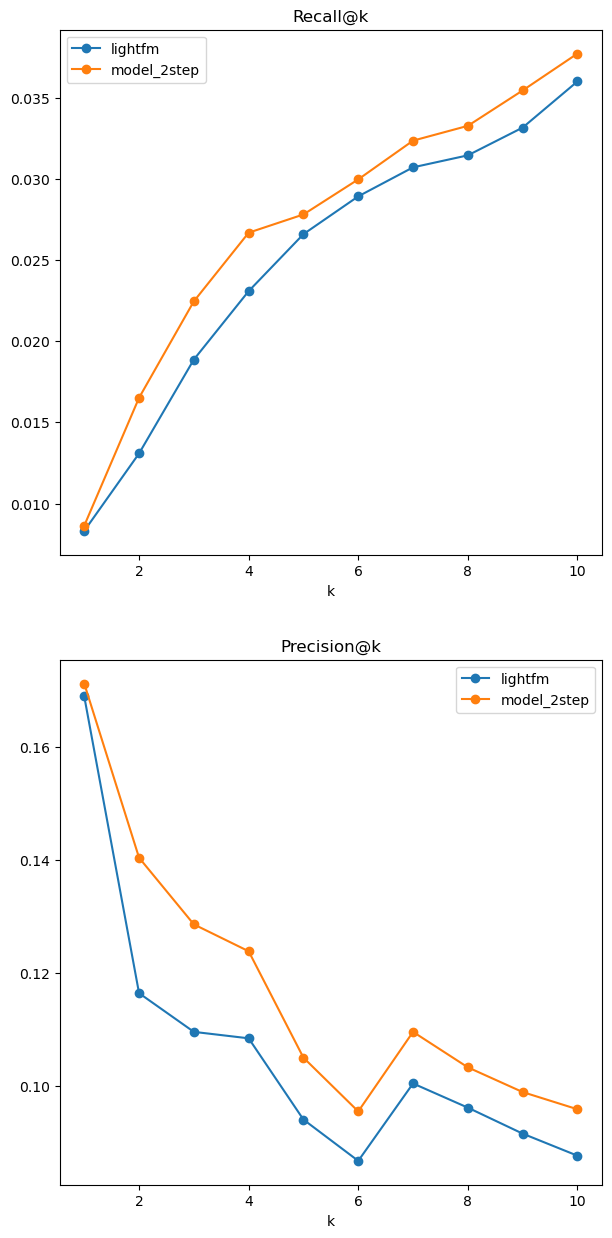

In [56]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(7, 15))

for indx, metric in enumerate([f'Recall@', f'Precision@']):
    for model in df_metrics.index:
        axes[indx].plot(range(1, 11), 
                        df_metrics.loc[model][[metric+f'{k}' for k in range(1, 11)]].values,
                        label=model, marker='o')
        axes[indx].legend()
        axes[indx].set_title(f'{metric}k')
        axes[indx].set_xlabel('k')